In [1]:
from model import BERTClassifier
import torch
from sklearn.metrics import confusion_matrix
from dataLoad import get_dataloader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns


/home/vupl/anaconda3/envs/transformer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_confusion_matrix(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            softmax = torch.nn.Softmax(dim=1)
            outputs = softmax(outputs)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
        
    return actual_labels, predictions

In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [5]:
path_politics = '/home/vupl/Documents/text_Classification_policy/0.csv'
path_normal = '/home/vupl/Documents/text_Classification_policy/1.csv'
path_neutral = '/home/vupl/Documents/text_Classification_policy/2.csv'
train_dataloader, val_dataloader = get_dataloader(path_politics, path_normal, path_neutral)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier().to(device)
model.load_state_dict(torch.load('/home/vupl/Documents/policy_classification_phobert/bert_classifier.pth'))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [7]:
actual_labels, predictions = get_confusion_matrix(model, val_dataloader, device)

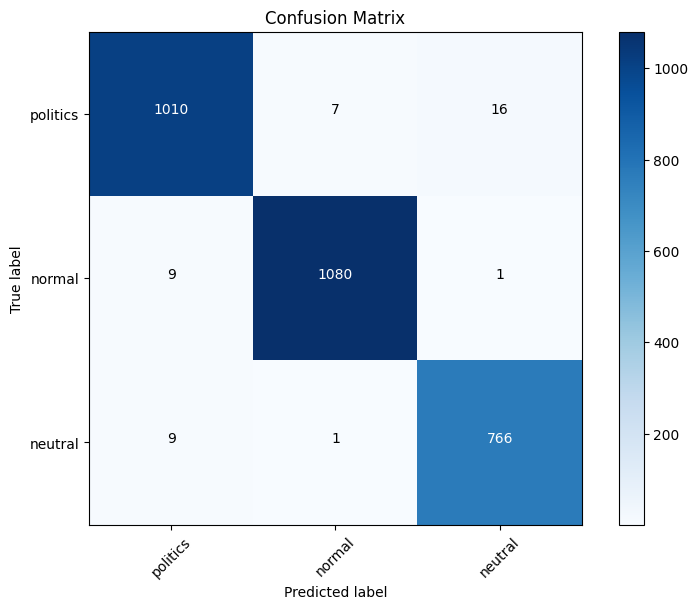

In [8]:
cm = confusion_matrix(actual_labels, predictions)
class_names = ['politics', 'normal', 'neutral']

# Vẽ ma trận nhầm lẫn
plot_confusion_matrix(cm, class_names)

# Lưu hình ảnh thành "confusion_matrix.png"
plt.savefig("confusion_matrix1.png")

# Hiển thị ma trận nhầm lẫn (tùy chọn)
plt.show()

In [ ]:
# calculate Recall, Precision, F1-score
from sklearn.metrics import classification_report
print(classification_report(actual_labels, predictions, target_names=class_names))

In [ ]:
# # plot distribution of precision and recall and f1
# sns.distplot(pe, hist=False, rug=True, label='Precision')
# sns.distplot(re, hist=False, rug=True, label='Recall')
# plt.xlabel('Precision and Recall')
# plt.ylabel('Density')
# plt.title('Distribution of Precision and Recall')
# plt.legend()
# plt.show()


In [6]:
import torch
from thop import profile
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base-v2')

# Set the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_text = "xin chào việt nam"
input_tokens = tokenizer(input_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Chuyển dữ liệu sang tensor và đưa lên thiết bị
input_ids = input_tokens["input_ids"].to(device)
attention_mask = input_tokens["attention_mask"].to(device)
inputs=(input_ids, attention_mask)
# Calculate FLOPs and parameters
macs, params = profile(model, inputs=(input_ids, attention_mask))
print('FLOPs: ', macs)
print('Params: ', params)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs:  10882584320.0
Params:  86173955.0


In [7]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the '{'vinai/phobert-base-v2'}' model: {total_params}")


Total parameters in the 'vinai/phobert-base-v2' model: 135525635


In [23]:
attention_mask.shape

torch.Size([1, 128])